In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import fetch_lfw_pairs
import os
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Subtract, Lambda,Dropout,Concatenate
from keras.optimizers import Adam, SGD , RMSprop
from keras.regularizers import l2
import keras.backend as K
from keras import activations
from keras import applications
import tensorflow as tf
#from keras.legacy import interfaces
import keras.backend as K
from keras.optimizers import Optimizer
import numpy as np
from keras.callbacks import EarlyStopping , ModelCheckpoint
from keras.initializers import RandomNormal


In [2]:
image_slice=(slice(70, 195), slice(65, 190))
from sklearn.datasets import fetch_lfw_pairs
lfw_pairs_train = fetch_lfw_pairs(subset='train',funneled=False,resize=1,slice_=image_slice,color=False)
lfw_pairs_train.pairs=lfw_pairs_train.pairs/255

In [3]:
list(lfw_pairs_train.target_names)

['Different persons', 'Same person']

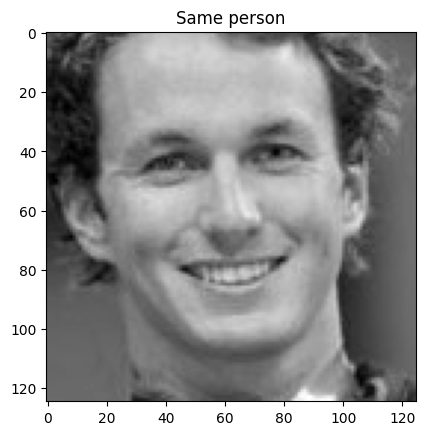

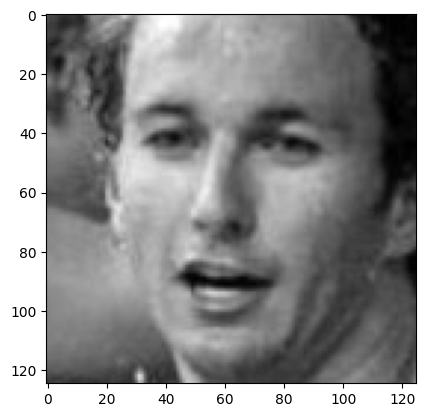

(125, 125)


In [4]:
ind=1
img1,img2=lfw_pairs_train.pairs[ind]
img1 = img1/255
img2 = img2/255
plt.title(lfw_pairs_train.target_names[lfw_pairs_train.target[ind]])
plt.imshow(img1,cmap='gray')
plt.show()
plt.show()
plt.imshow(img2,cmap='gray')
plt.show()
plt.show()
print(img1.shape)

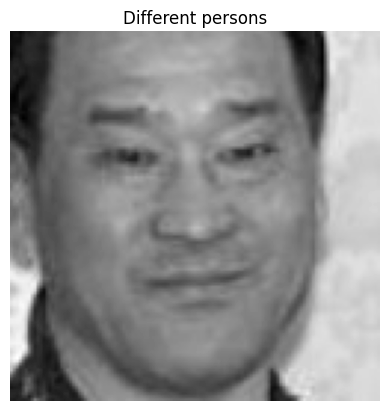

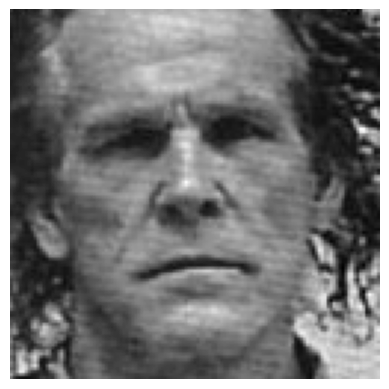

In [5]:
ind=2000
img1,img2=lfw_pairs_train.pairs[ind]
img1 = img1/255
img2 = img2/255
plt.title(lfw_pairs_train.target_names[lfw_pairs_train.target[ind]])
plt.imshow(img1,cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(img2,cmap='gray')
plt.axis('off')
plt.show()

In [6]:
# =============================================================================
# save model
# =============================================================================

def save_model(model,name):
    # Save the weights
    model.save_weights('models/'+name+'_'+'model_weights.h5')

    # Save the model architecture
    with open('models/'+name+'_'+'model_architecture.json', 'w') as f:
        f.write(model.to_json())



# =============================================================================
# load model
# =============================================================================
from keras.models import model_from_json

def load_model(name):
    # Model reconstruction from JSON file
    with open('models/'+name+'_'+'model_architecture.json', 'r') as f:
        model = model_from_json(f.read())

    # Load weights into the new model
    model.load_weights('models/'+name+'_'+'model_weights.h5')
    return model

In [7]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return  K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))

## model

In [8]:
shape=lfw_pairs_train.pairs.shape[2]
K.clear_session()

learning_rate = 1e-4

# l2-regularization penalization for each layer
l2_penalization = {}
l2_penalization['Conv1'] = 1e-2
l2_penalization['Conv2'] = 1e-2
l2_penalization['Conv3'] = 1e-2
l2_penalization['Conv4'] = 1e-2
l2_penalization['Dense1'] = 1e-4

input_shape= (shape, shape, 1)

In [9]:
convolutional_net = Sequential()

convolutional_net.add(Conv2D(filters=32, kernel_size=(10, 10),
                             activation='relu',
                             input_shape=input_shape,
                             kernel_regularizer=l2(
                                 l2_penalization['Conv1']),
                             name='Conv1'))

convolutional_net.add(MaxPool2D())


convolutional_net.add(Conv2D(filters=64, kernel_size=(7, 7),
                             activation='relu',
                             kernel_regularizer=l2(
                                 l2_penalization['Conv2']),
                             name='Conv2'))
convolutional_net.add(MaxPool2D())

convolutional_net.add(Flatten())

convolutional_net.add(
    Dense(units=100, activation='sigmoid',kernel_regularizer=l2(l2_penalization['Dense1']),name='Dense1'))

In [10]:
# Now the pairs of images
input_image_1 = Input(input_shape)
input_image_2 = Input(input_shape)

encoded_image_1 = convolutional_net(input_image_1)
encoded_image_2 = convolutional_net(input_image_2)

# L1 distance layer between the two encoded outputs
# One could use Subtract from Keras, but we want the absolute value
distance=Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([encoded_image_1, encoded_image_2])

model = Model([input_image_1, input_image_2], distance)

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms,metrics=['binary_accuracy'])

In [11]:
def plot_history(history,name):
    # Plot training & validation accuracy values
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig(str(name)+'_accuracy')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'validation'], loc='upper left')
    plt.savefig(str(name)+'_loss')
    plt.show()

In [12]:
def train_validation_pairs(lfw_pairs_train, valid=0.2):
    """
    :param lfw_pairs_train:
    :param valid:
    :return:
    """
    ln = len(lfw_pairs_train.target)

    indices_same = np.random.choice(np.argwhere(lfw_pairs_train.target == 1).flatten(), int((1-valid) * ln / 2))
    indices_different = np.random.choice(np.argwhere(lfw_pairs_train.target == 0).flatten(),
                                         int((1 - valid) * ln / 2))
    indices = np.concatenate((indices_same, indices_different), axis=0)
    x_train = lfw_pairs_train.pairs[indices]
    x_train = [np.expand_dims(x_train[:, 0], axis=3), np.expand_dims(x_train[:, 1], axis=3)]
    y_train = lfw_pairs_train.target[indices]

    not_train_indices = np.arange(ln)[~np.isin(np.arange(ln), indices)]
    indices_same_valid = np.random.choice(not_train_indices[np.where(not_train_indices < int(ln / 2))],
                                          int(valid  * ln / 2))
    indices_different_valid = np.random.choice(not_train_indices[np.where(not_train_indices >= int(ln / 2))],
                                               int(valid  * ln / 2))
    indices_valid = np.concatenate((indices_same_valid, indices_different_valid), axis=0)

    x_valid = lfw_pairs_train.pairs[indices_valid]
    x_valid = [np.expand_dims(x_valid[:, 0], axis=3), np.expand_dims(x_valid[:, 1], axis=3)]
    y_valid = lfw_pairs_train.target[indices_valid]

    return x_train, y_train, x_valid, y_valid


def persons_same_different_split(x_train, y_train, percent_same=0.5,percent_diff=0.5):
    """
    :param lfw_pairs_train:
    :param percent_same:
    :return:
    """
    ln = len(y_train)

    indices_same = np.random.choice(np.argwhere(y_train == 1).flatten(), int(percent_same * ln / 2))
    indices_different = np.random.choice(np.argwhere(y_train == 0).flatten(),
                                         int(percent_diff * ln / 2))
    indices = np.concatenate((indices_same, indices_different), axis=0)
    x_train = [x_train[0][indices],x_train[1][indices]]
    y_train = y_train[indices]
    return x_train, y_train

In [13]:
best_model='models/best_model.h5'
early_stopping_monitor = EarlyStopping(patience=3)
checkpoint = ModelCheckpoint(filepath=best_model, monitor='val_loss', save_best_only=True)
batch_size = 16
epochs=10
iteration=1
percents_same=np.linspace(0.5,1,iteration)
percents_diff=np.linspace(0.2,1,iteration)

In [14]:
hist=[]
x_train, y_train, x_valid, y_valid=train_validation_pairs(lfw_pairs_train, valid=0.1)
for i in range(iteration):
    print(i)
    percent_same=percents_same[i]
    percent_diff=percents_diff[i]
    x_train_percent,y_train_percent = persons_same_different_split(x_train, y_train, percent_same=1,percent_diff=1) 
    history=model.fit(x=x_train_percent,y=1-y_train_percent,validation_data=(x_valid,1-y_valid),epochs=epochs,batch_size=batch_size,verbose=True,callbacks=[early_stopping_monitor,checkpoint])
    hist.append(history)
    model.load_weights(best_model)

0
Epoch 1/10


TypeError: in user code:

    File "C:\Users\92301\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\92301\AppData\Local\Temp\ipykernel_11412\2014082220.py", line 16, in contrastive_loss  *
        return  K.mean((1 - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0)))

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int32 of argument 'x'.


In [ ]:
for i,h in enumerate(hist):
    print('\n******************'+str(i)+'******************\n')
    if i==len(hist)-1:
        plot_history(h,i)

In [ ]:
model.load_weights(best_model)

lfw_pairs_test = fetch_lfw_pairs(subset='test',funneled=False,resize=1,slice_=image_slice,color=False)
lfw_pairs_test.pairs=lfw_pairs_test.pairs/255

In [ ]:
x_test,y_test,_,_=train_validation_pairs(lfw_pairs_test , valid=0)
model.evaluate(x_test,1-y_test)    

In [ ]:
save_model(model,'0.69_newloss_5iter_10epoch_16_batch')